# Step 1: Data Preprocessing

In [4]:
import pandas as pd

# Load datasets
customers = pd.read_csv('C:/Users/Admin/Desktop/customers.csv')
products = pd.read_csv('C:/Users/Admin/Desktop/products.csv')
transactions = pd.read_csv('C:/Users/Admin/Desktop/transactions.csv')

In [5]:
# Merge datasets
data = pd.merge(transactions, customers, on='CustomerID')
data = pd.merge(data, products, on='ProductID')

In [6]:
# Convert dates to datetime format
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

In [7]:
# Display the first few rows of the merged dataset
print(data.head())

  TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe 2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia 2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe 2024-04-04   
3      601.36   300.68  Travis Campbell  South America 2024-04-11   
4      902.04   300.68    Timothy Perez         Europe 2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker  Electronic

# Step 2: Feature Engineering

Create features for clustering based on customer profiles and transaction behavior.

In [18]:
# Feature 1: Total spending per customer
total_spending = data.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spending.columns = ['CustomerID', 'TotalSpending']

In [19]:
# Feature 2: Average transaction value per customer
avg_transaction_value = data.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.columns = ['CustomerID', 'AvgTransactionValue']

In [20]:
# Feature 3: Number of transactions per customer
num_transactions = data.groupby('CustomerID')['TransactionID'].count().reset_index()
num_transactions.columns = ['CustomerID', 'NumTransactions']

In [21]:
# Feature 4: Days since signup
data['DaysSinceSignup'] = (pd.to_datetime('today') - data['SignupDate']).dt.days
days_since_signup = data.groupby('CustomerID')['DaysSinceSignup'].first().reset_index()

In [22]:
# Feature 5: Favorite product category (most purchased category)
favorite_category = data.groupby(['CustomerID', 'Category']).size().reset_index(name='Count')
favorite_category = favorite_category.loc[favorite_category.groupby('CustomerID')['Count'].idxmax()]
favorite_category = favorite_category[['CustomerID', 'Category']]
favorite_category.columns = ['CustomerID', 'FavoriteCategory']

In [23]:
# Merge all features into a single dataframe
customer_features = pd.merge(total_spending, avg_transaction_value, on='CustomerID')
customer_features = pd.merge(customer_features, num_transactions, on='CustomerID')
customer_features = pd.merge(customer_features, days_since_signup, on='CustomerID')
customer_features = pd.merge(customer_features, favorite_category, on='CustomerID')

In [24]:
# Display the first few rows of the customer features dataframe
print(customer_features.head())

  CustomerID  TotalSpending  AvgTransactionValue  NumTransactions  \
0      C0001        3354.52              670.904                5   
1      C0002        1862.74              465.685                4   
2      C0003        2725.38              681.345                4   
3      C0004        5354.88              669.360                8   
4      C0005        2034.24              678.080                3   

   DaysSinceSignup FavoriteCategory  
0              938      Electronics  
1             1085         Clothing  
2              332       Home Decor  
3              847            Books  
4              902      Electronics  


# Step 3: Encode Categorical Columns

Encode categorical columns (e.g., FavoriteCategory) using one-hot encoding.

In [25]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the 'FavoriteCategory' column
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_categories = encoder.fit_transform(customer_features[['FavoriteCategory']])
encoded_categories_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['FavoriteCategory']))

In [26]:
# Drop the original 'FavoriteCategory' column and concatenate the encoded columns
customer_features_encoded = customer_features.drop('FavoriteCategory', axis=1)
customer_features_encoded = pd.concat([customer_features_encoded, encoded_categories_df], axis=1)

In [27]:
# Display the first few rows of the encoded dataframe
print(customer_features_encoded.head())

  CustomerID  TotalSpending  AvgTransactionValue  NumTransactions  \
0      C0001        3354.52              670.904                5   
1      C0002        1862.74              465.685                4   
2      C0003        2725.38              681.345                4   
3      C0004        5354.88              669.360                8   
4      C0005        2034.24              678.080                3   

   DaysSinceSignup  FavoriteCategory_Clothing  FavoriteCategory_Electronics  \
0              938                        0.0                           1.0   
1             1085                        1.0                           0.0   
2              332                        0.0                           0.0   
3              847                        0.0                           0.0   
4              902                        0.0                           1.0   

   FavoriteCategory_Home Decor  
0                          0.0  
1                          0.0  
2          

# Step 4: Normalize the Features

Normalize the features to ensure all features are on the same scale.

In [28]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features_encoded.iloc[:, 1:])  # Exclude 'CustomerID'

In [29]:
# Convert scaled features back to a dataframe (optional)
scaled_features_df = pd.DataFrame(scaled_features, columns=customer_features_encoded.columns[1:])

In [30]:
# Display the first few rows of the scaled features
print(scaled_features_df.head())

   TotalSpending  AvgTransactionValue  NumTransactions  DaysSinceSignup  \
0      -0.061701            -0.070263        -0.011458         1.148752   
1      -0.877744            -0.934933        -0.467494         1.600431   
2      -0.405857            -0.026271        -0.467494        -0.713270   
3       1.032547            -0.076769         1.356650         0.869141   
4      -0.783929            -0.040028        -0.923530         1.038137   

   FavoriteCategory_Clothing  FavoriteCategory_Electronics  \
0                  -0.540562                      1.849925   
1                   1.849925                     -0.540562   
2                  -0.540562                     -0.540562   
3                  -0.540562                     -0.540562   
4                  -0.540562                      1.849925   

   FavoriteCategory_Home Decor  
0                    -0.517219  
1                    -0.517219  
2                     1.933415  
3                    -0.517219  
4          

# Step 5: Apply K-Means Clustering

Use the Elbow Method to determine the optimal number of clusters.

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [32]:
# Use the Elbow Method to find the optimal number of clusters
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Window

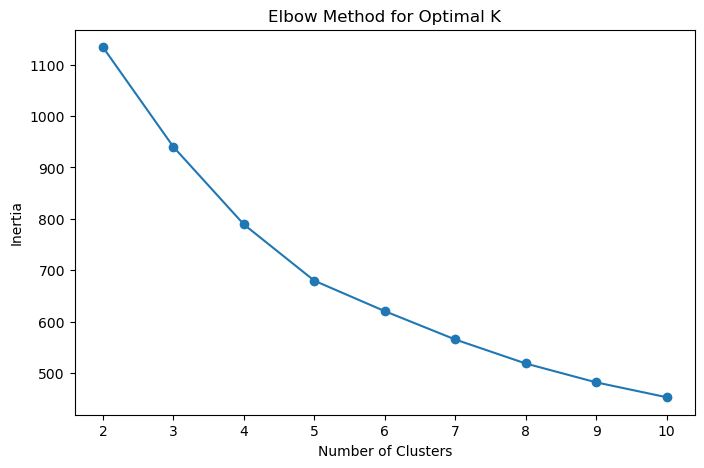

In [33]:
# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Step 6: Perform Clustering

Based on the Elbow Method, choose the optimal number of clusters and perform clustering.

In [34]:
# Perform K-Means clustering with the chosen number of clusters
k = 4  # Example: Choose k=4 based on the Elbow Method
kmeans = KMeans(n_clusters=k, random_state=42)
customer_features_encoded['Cluster'] = kmeans.fit_predict(scaled_features)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [35]:
# Display the first few rows of the clustered dataframe
print(customer_features_encoded.head())

  CustomerID  TotalSpending  AvgTransactionValue  NumTransactions  \
0      C0001        3354.52              670.904                5   
1      C0002        1862.74              465.685                4   
2      C0003        2725.38              681.345                4   
3      C0004        5354.88              669.360                8   
4      C0005        2034.24              678.080                3   

   DaysSinceSignup  FavoriteCategory_Clothing  FavoriteCategory_Electronics  \
0              938                        0.0                           1.0   
1             1085                        1.0                           0.0   
2              332                        0.0                           0.0   
3              847                        0.0                           0.0   
4              902                        0.0                           1.0   

   FavoriteCategory_Home Decor  Cluster  
0                          0.0        2  
1                         

# Step 7: Evaluate Clustering

Calculate the Davies-Bouldin Index (DB Index) and other metrics.

In [36]:
from sklearn.metrics import davies_bouldin_score

# Calculate DB Index
db_index = davies_bouldin_score(scaled_features, customer_features_encoded['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.2f}')

Davies-Bouldin Index: 1.43


# Step 8: Visualize Clusters

Use PCA to reduce the dimensionality of the data and visualize the clusters.

In [37]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

In [38]:
# Add PCA components to the dataframe
customer_features_encoded['PCA1'] = pca_features[:, 0]
customer_features_encoded['PCA2'] = pca_features[:, 1]

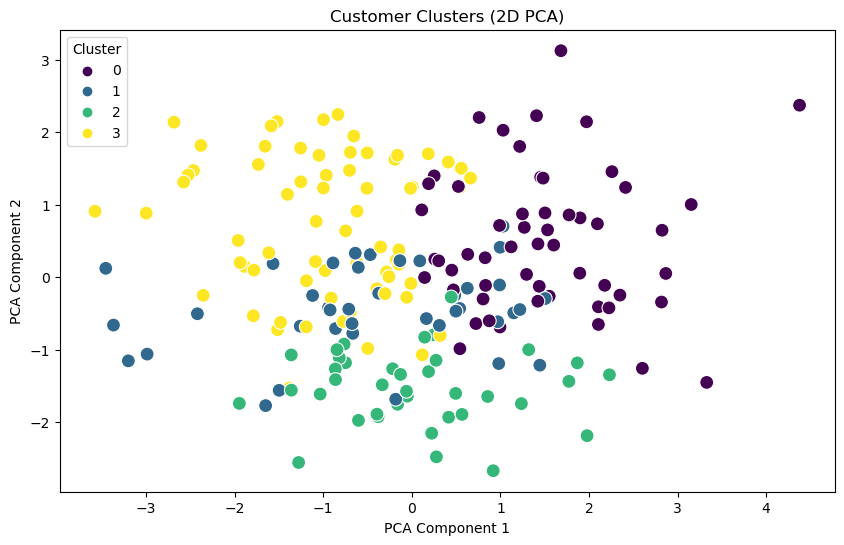

In [39]:
# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features_encoded, palette='viridis', s=100)
plt.title('Customer Clusters (2D PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()